In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
def distance_from(df, Lat, Long):
    Lat = np.deg2rad(Lat)
    Long = np.deg2rad(Long)
    x_pos = np.cos(Lat)*np.sin(Long)
    y_pos = np.cos(Lat)*np.cos(Long)
    z_pos = np.sin(Lat)
    return ( (df.x_pos - x_pos)**2 + (df.y_pos - y_pos)**2 + (df.z_pos - z_pos)**2)**(1/2)

The database is available on [Kaggle](https://www.kaggle.com/usgs/earthquake-database)

In [3]:
Fields = ['Date','Time','Latitude','Longitude','Type','Magnitude']
df = pd.read_csv('database.csv', usecols=Fields)
df.sample(5)

,Date,Time,Latitude,Longitude,Type,Magnitude
8093,07/20/1986,14:29:46,37.567,-118.4360,Earthquake,5.84
22436,11/10/2014,10:04:21,-22.773,171.4529,Earthquake,5.90
12252,01/06/1995,21:59:29,9.189,126.1790,Earthquake,5.80
20221,08/16/2010,03:30:53,-17.759,65.6470,Earthquake,6.30
7897,03/19/1986,21:28:02,12.413,141.7620,Earthquake,5.50


In [4]:
df.dtypes

Date          object
Time          object
Latitude     float64
Longitude    float64
Type          object
Magnitude    float64
dtype: object

In [5]:
# Continue Cleaning
df = df[df.Date.str.len() < 15] # Removes 3 rows with malformed dates
df = df[df.Type.isin(['Earthquake'])] # removes explosions and rock bursts

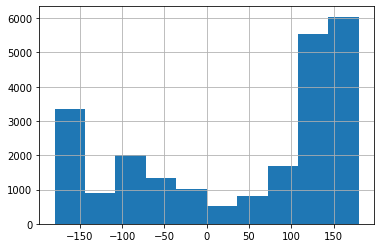

In [6]:
df.Longitude.hist()

In [7]:
# Calculations
df['Datetime'] = pd.to_datetime(df.Date +' '+ df.Time)

df['Year'] = df['Datetime'].map(lambda x: x.year)
df['Rounded_Magnitude'] = np.floor(df.Magnitude)

df['Last_Quake'] = df.Datetime.diff()
df = df[df['Last_Quake'].notna()]

df['Last_Quake_sec'] = df['Last_Quake'].map(lambda x: x.total_seconds()) # Last Quake (s)
df["Datetime"] = df["Datetime"].astype("datetime64")

df['Latitude_rad'] = np.deg2rad(df.Latitude)
df['Longitude_rad'] = np.deg2rad(df.Longitude)

df['x_pos'] = np.cos(df.Latitude_rad)*np.sin(df.Longitude_rad)
df['y_pos'] = np.cos(df.Latitude_rad)*np.cos(df.Longitude_rad)
df['z_pos'] = np.sin(df.Latitude_rad)

Tokyo = [35.67,139.65]
San_Fran = [37.77,122.42]
Denver = [39.74,-104.99]

# Calculates straightline distance from a given Lat/Long point to each earthquake
# Assumes earth is a sphere with radius=1
# Does not consider arc length, just straight distance
# So the poles are 2 units apart, the equator is sqrt(2) from each pole, not pi and pi/2
df['Dist_Tokyo'] = distance_from(df,Tokyo[0],Tokyo[1])
df['Dist_San_Fran'] = distance_from(df,San_Fran[0],San_Fran[1])
df['Dist_Denver'] = distance_from(df,Denver[0],Denver[1])

df.reset_index(drop=True)

df.count()

Date                 23228
Time                 23228
Latitude             23228
Longitude            23228
Type                 23228
Magnitude            23228
Datetime             23228
Year                 23228
Rounded_Magnitude    23228
Last_Quake           23228
Last_Quake_sec       23228
Latitude_rad         23228
Longitude_rad        23228
x_pos                23228
y_pos                23228
z_pos                23228
Dist_Tokyo           23228
Dist_San_Fran        23228
Dist_Denver          23228
dtype: int64

In [8]:
df.head()

,Date,Time,Latitude,Longitude,Type,Magnitude,Datetime,Year,Rounded_Magnitude,Last_Quake,Last_Quake_sec,Latitude_rad,Longitude_rad,x_pos,y_pos,z_pos,Dist_Tokyo,Dist_San_Fran,Dist_Denver
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,5.8,1965-01-04 11:29:49,1965,5.0,1 days 21:45:31,164731.0,0.032515,2.222712,0.794503,-0.606389,0.032510,0.612724,0.621217,1.702209
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,6.2,1965-01-05 18:05:58,1965,6.0,1 days 06:36:09,110169.0,-0.359171,-3.036384,-0.098313,-0.931012,-0.351499,1.166416,1.331419,1.390338
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,5.8,1965-01-08 18:49:43,1965,5.0,3 days 00:43:45,261825.0,-1.031071,-0.411147,-0.205386,0.471074,-0.857850,1.949312,1.929825,1.726013
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,5.8,1965-01-09 13:32:50,1965,5.0,0 days 18:43:07,67387.0,0.208357,2.206567,0.787212,-0.580955,0.206853,0.459641,0.451254,1.635202
5,01/10/1965,13:36:32,-13.405,166.629,Earthquake,6.7,1965-01-10 13:36:32,1965,6.0,1 days 00:03:42,86622.0,-0.233961,2.908225,0.224955,-0.946387,-0.231833,0.928365,1.087032,1.501385


Text(0.5, 0, 'Time since last Quake (days)')

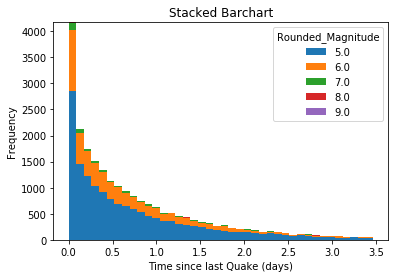

In [9]:
(df[df.Last_Quake_sec < 3*10**5].pivot(columns='Rounded_Magnitude')['Last_Quake_sec']/(60*60*24)).plot(kind = 'hist', stacked=True, bins=40)

plt.title('Stacked Barchart')
plt.xlabel('Time since last Quake (days)')

# Use this data to answer the question, given the last earthquake was x seconds ago, what is the probability of a severe earthquake? What is the probability of a mild(er) earthquake? Does this change overtime?

Hypothesis: The probability of strong earthquakes increases with extended periods of time without earthquakes.

# Is the risk of severe earthquakes location specific? Which has more earthquakes, Tokyo or San Francisco?

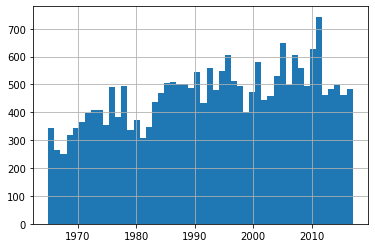

In [10]:
df.Datetime.hist(bins=50)

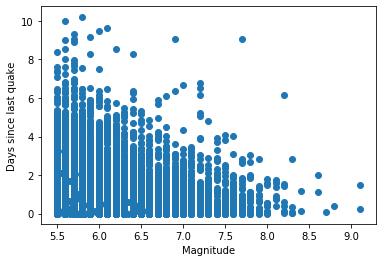

In [11]:
plt.scatter(df.Magnitude,df.Last_Quake_sec/(60*60*24))

plt.ylabel('Days since last quake')
plt.xlabel('Magnitude')

plt.show()

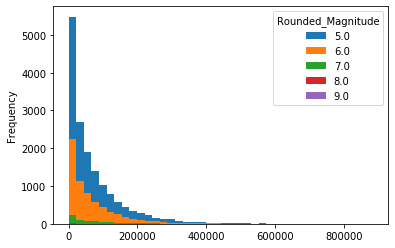

In [12]:
df[df.Last_Quake_sec < 10**6].pivot(columns='Rounded_Magnitude')['Last_Quake_sec'].plot(kind = 'hist', stacked=False,bins=40)

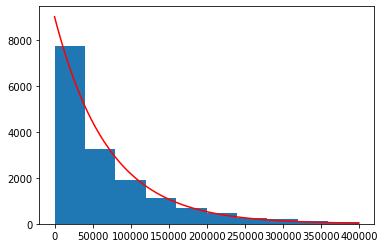

In [13]:
max_x = 4*10**5

df[(df.Magnitude < 6.0) & (df.Last_Quake_sec < max_x)].Last_Quake_sec.hist()
plt.grid()
x = np.linspace(0,max_x,100)
y = 9000 * (2.7**(-1*x/(7*10**4)))
plt.plot(x,y,color='r')

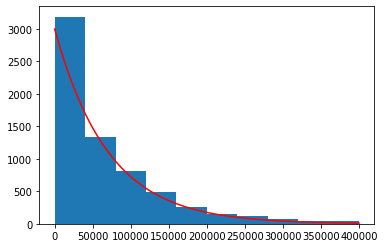

In [14]:
max_x - 5 * 10**5

df[(6.0<=df.Magnitude) & (df.Magnitude<7.0) & (df.Last_Quake_sec<max_x)].Last_Quake_sec.hist()
plt.grid()
x = np.linspace(0,max_x,100)
y = 3000 * (2.7**(-1*x/(7*10**4)))
plt.plot(x,y,color='r')

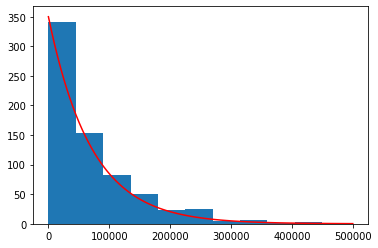

In [15]:
max_x = 5 * 10**5

df[(7.0<=df.Magnitude) & (df.Magnitude<8.0) & (df.Last_Quake_sec<max_x)].Last_Quake_sec.hist()
plt.grid()
x = np.linspace(0,max_x,100)
y = 350 * (2.7**(-1*x/(7*10**4)))
plt.plot(x,y,color='r')

In [16]:
df[(8.0<=df.Magnitude)].count()

Date                 40
Time                 40
Latitude             40
Longitude            40
Type                 40
Magnitude            40
Datetime             40
Year                 40
Rounded_Magnitude    40
Last_Quake           40
Last_Quake_sec       40
Latitude_rad         40
Longitude_rad        40
x_pos                40
y_pos                40
z_pos                40
Dist_Tokyo           40
Dist_San_Fran        40
Dist_Denver          40
dtype: int64

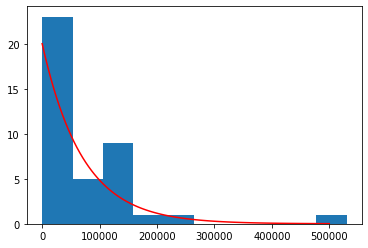

In [17]:
max_x = 5*10**5

df[(8.0<=df.Magnitude)].Last_Quake_sec.hist()
plt.grid()
x = np.linspace(0,max_x,100)
y = 20 * (2.7**(-1*x/(7*10**4)))
plt.plot(x,y,color='r')

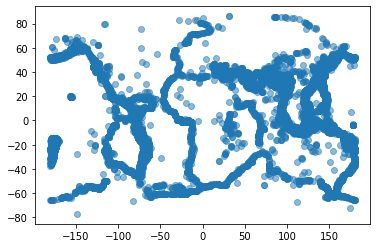

In [18]:
plt.scatter(df.Longitude.values,df.Latitude.values, alpha=0.5)

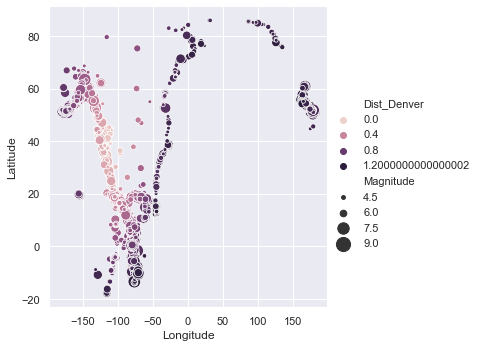

In [21]:
sns.set(style="darkgrid")
sns.relplot(x='Longitude', y='Latitude', size='Magnitude',sizes=(15,200),hue='Dist_Denver',data=df[df.Dist_Denver < 1])

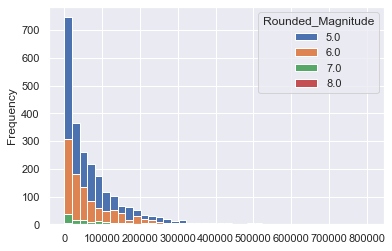

In [23]:
df[(df.Last_Quake_sec < 10**6) & (df.Dist_Denver < 1)].pivot(columns='Rounded_Magnitude')['Last_Quake_sec'].plot(kind = 'hist', stacked=False,bins=40)

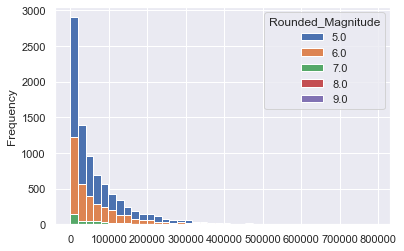

In [24]:
df[(df.Last_Quake_sec < 10**6) & (df.Dist_Tokyo < 1)].pivot(columns='Rounded_Magnitude')['Last_Quake_sec'].plot(kind = 'hist', stacked=False,bins=40)

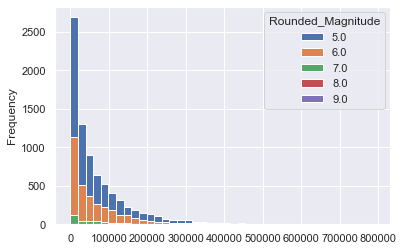

In [25]:
df[(df.Last_Quake_sec < 10**6) & (df.Dist_San_Fran < 1)].pivot(columns='Rounded_Magnitude')['Last_Quake_sec'].plot(kind = 'hist', stacked=False,bins=40)